In [300]:
import numpy as np
import pandas as pd
from functools import reduce
import pathlib
import matplotlib.pyplot as plt
import gzip
import scipy.sparse as sparse

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [301]:
# Define the figure size and dpi
fig_width = 6.9  # inches
fig_height = 3.5  # inches
fig_dpi = 350

plt.rcParams.update({
    'figure.figsize': (fig_width, fig_height),
    'figure.dpi': fig_dpi,

    # Fonts
    'font.size': 12,

    # Axes
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'axes.linewidth': 1,
    'axes.grid': True,
    'grid.linestyle': ':',
    'grid.linewidth': 1,
    'grid.color': 'gray',

    # Legend
    'legend.fontsize': 8,
    'legend.frameon': True,
    'legend.framealpha': 0.8,
    'legend.fancybox': False,
    'legend.edgecolor': 'gray',
    'legend.facecolor': 'white',
    'legend.borderaxespad': 0.5,
    'legend.borderpad': 0.4,
    'legend.labelspacing': 0.5,

    # Lines
    'lines.linewidth': 2.0,
    'lines.markersize': 2,
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
})

### Paths to HTMs

In [302]:
path_models_ctm_cordis = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Datasets/CORDIS/models_htm_ctm")
path_models_mallet_cordis = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Datasets/CORDIS/htm_variability_models_ctm/5_tpc_root")
path_models_ctm_s2cs = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Datasets/S2CS/models_htm_ctm")
path_models_mallet_s2cs = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Datasets/S2CS/models_htm")
path_models = path_models_mallet_cordis
if path_models == path_models_ctm_cordis:
    corpus_name = "cordis"
    model_type = "ctm"
elif path_models == path_models_mallet_cordis:
    corpus_name = "cordis"
    model_type = "mallet"
elif path_models == path_models_ctm_s2cs:
    corpus_name = "s2cs"
    model_type = "ctm"
elif path_models == path_models_mallet_s2cs:
    corpus_name = "s2cs"
    model_type = "mallet"
    
folder_save = "images/ctm_cordis_5_tpc_root" #"images/ctm_cordis_5_tpc_root"

### Get root models

In [ ]:
dfs = []
for entry in path_models.iterdir():
    # check if it is a root model
    if "root" in entry.as_posix():
        # Path to the root model
        path = entry
        
        # Thr and exp_tpc do not apply for the root model
        thr = -1
        exp_tpc = -1
        
        # Experiment iteration
        iter_ = int(entry.as_posix().split("model_")[1].split("_")[0])
        
        # Size of the topics
        alphas = np.load(path.joinpath('TMmodel/alphas.npy')).tolist()
        
        # Coherences (CV and NPMI)
        cohrs_cv = np.load(path.joinpath('TMmodel/topic_coherence.npy')).tolist()
        cohrs_npmi = np.load(path.joinpath('TMmodel/new_topic_coherence.npy'), allow_pickle=True).tolist()
        #if len(cohrs) > len(alphas):
        #    cohrs_cv = cohrs[0:len(alphas)]
        #    cohrs_npmi = cohrs[len(alphas):]
        #elif len(cohrs) == len(alphas):
        #    cohrs_cv = cohrs
        #    cohrs_npmi = [0] * len(alphas)
        
        # Topics' entropies
        entropies = np.load(path.joinpath('TMmodel/topic_entropy.npy')).tolist()
        
        # TD
        td = np.load(path.joinpath('TMmodel/td.npy'))
        
        # IRBO 
        rbo = np.load(path.joinpath('TMmodel/rbo.npy'))
        
        # Ids of the topics
        tpc_ids = np.arange(0,len(alphas),1)
        
        # Corpus size
        if path.joinpath('corpus.txt').is_file():
            corpus = [line.rsplit(' 0 ')[1].strip() for line in open(
                path.joinpath('corpus.txt'), encoding="utf-8").readlines()]
            size = len(corpus)
        elif path.joinpath('corpus.parquet').is_dir():
            dfc = pd.read_parquet(path.joinpath('corpus.parquet'))
            size = len(dfc)
            
        # Create dataframe for the root model
        root_tpc_df = pd.DataFrame(
            {'iter': [iter_] * len(alphas),
             'path': [path] * len(alphas),
             'cohrs_cv': cohrs_cv,
             'cohrs_npmi': cohrs_npmi,
             'entropies': entropies,
             'td': [td] * len(alphas),
             'rbo': [rbo] * len(alphas),
             'alphas': alphas,
             'tpc_ids': tpc_ids,
             'thr': [thr] * len(alphas),
             'exp_tpc': [exp_tpc] * len(alphas),
             'tr_tpcs': [0] * len(alphas),
            })
        
        # Append to the list of dataframes to concatenate them
        dfs.append(root_tpc_df)
df = pd.concat(dfs)
df = df.sort_values(by=['iter'])
df

In [ ]:
if df.iloc[0].path.joinpath('corpus.txt').is_file():
    corpus = [line.rsplit(' 0 ')[1].strip() for line in open(
                df.iloc[0].path.joinpath('corpus.txt'), encoding="utf-8").readlines()]
    root_size = len(corpus)
elif df.iloc[0].path.joinpath('corpus.parquet').is_dir() or df.iloc[0].path.joinpath('corpus.parquet').is_file():
    dfc = pd.read_parquet(df.iloc[0].path.joinpath('corpus.parquet'))
    root_size = len(dfc)
root_size

### Get submodels

In [ ]:
# Iter over each root model (according to its corresponding iteration, iter)
concats = [df]
not_finished = []
for el in df.iter.unique():
    path_root = df[df.iter == el].iloc[0].path
    for entry in path_root.iterdir():
        if entry.joinpath('TMmodel/topic_coherence.npy').is_file() and not entry.as_posix().endswith("old"):
        
            if "ws" in entry.as_posix():
                thr = 0
                size = 0
            else:
                thr = float(entry.as_posix().split("thr_")[1].split("_")[0])
                
                if entry.joinpath('corpus.txt').is_file():
                    corpus = [line.rsplit(' 0 ')[1].strip() for line in open(
                                entry.joinpath('corpus.txt'), encoding="utf-8").readlines()]
                    size = len(corpus)
                elif entry.joinpath('corpus.parquet').is_dir():
                    dfc = pd.read_parquet(entry.joinpath('corpus.parquet'))
                    size = len(dfc)
                size = size * 100 / root_size

            # get topic from which the submodel is generated
            exp_tpc = int(entry.as_posix().split("from_topic_")[1].split("_")[0])
            
            
            # Size of the topics
            alphas = np.load(entry.joinpath('TMmodel/alphas.npy')).tolist()
        
            # Alphas submodel is the mean of the cohr of its topics
            alpha = np.mean(alphas)
            
            # Coherences (CV and NPMI)
            cohrs_cv = np.load(entry.joinpath('TMmodel/topic_coherence.npy')).tolist()
            cohrs_npmi = np.load(entry.joinpath('TMmodel/new_topic_coherence.npy'), allow_pickle=True).tolist()
            if cohrs_npmi is None:
                cohrs_npmi = [0]*len(cohrs_cv)
                print(entry)
            #if len(cohrs) > len(alphas):
            #    cohrs_cv = cohrs[0:len(alphas)]
            #    cohrs_npmi = cohrs[len(alphas):]
            #elif len(cohrs) == len(alphas):
            #    cohrs_cv = cohrs
            #    cohrs_npmi = [0] * len(alphas)
            
            # cohr submodel is the mean of the cohr of its topics
            cohr_cv = np.mean(cohrs_cv)
            cohr_npmi = np.mean(cohrs_npmi)
            
            # TD
            td = np.load(entry.joinpath('TMmodel/td.npy'))

            # IRBO 
            rbo = np.load(entry.joinpath('TMmodel/rbo.npy'))
            
            # Topics' entropies
            entropy = np.mean(np.load(entry.joinpath('TMmodel/topic_entropy.npy')).tolist())
            
            tr_tpcs = int(entry.as_posix().split("train_with_")[1].split("_")[0])
            
            # add entry of submodel to dataframe
            root_tpc_df = pd.DataFrame(
            {'iter': [el],
             'path': [entry],
             'cohrs_cv': [cohr_cv],
             'cohrs_npmi': [cohr_npmi],
             'entropies': [entropy],
             'alphas': [alpha],
             'td': [td],
             'rbo': [rbo],
             'tpc_ids': [exp_tpc],
             'thr': [thr],
             'exp_tpc': [exp_tpc],
             'size': [size],
             'tr_tpcs': [tr_tpcs]
            })
            concats.append(root_tpc_df)
        else:
            not_finished.append(entry)
df = pd.concat(concats)

### Save df

In [ ]:
path_save = "/export/usuarios_ml4ds/lbartolome/Datasets/CORDIS/htm_results/ctm"
df.to_csv(pathlib.Path(path_save).joinpath("cordis_5_tpc_root.csv"))   

### Read df

In [304]:
path_save = "/export/usuarios_ml4ds/lbartolome/Datasets/CORDIS/htm_results/mallet"
df = pd.read_csv(pathlib.Path(path_save).joinpath("cordis_5_tpc_root.csv"))  
df

,Unnamed: 0,iter,path,cohrs_cv,cohrs_npmi,entropies,td,rbo,alphas,tpc_ids,thr,exp_tpc,tr_tpcs,size
0,4,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.663521,0.093825,0.747615,0.933333,0.972898,0.106817,4,-1.0,-1,0,NaN
1,3,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.640263,0.073220,0.769471,0.933333,0.972898,0.185179,3,-1.0,-1,0,NaN
2,2,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.790402,0.112431,0.760219,0.933333,0.972898,0.200007,2,-1.0,-1,0,NaN
3,1,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.546475,0.037314,0.761661,0.933333,0.972898,0.252668,1,-1.0,-1,0,NaN
4,0,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.615635,0.068360,0.752374,0.933333,0.972898,0.255330,0,-1.0,-1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1550,0,10,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.649928,0.126307,0.745514,0.955556,0.981473,0.166667,3,0.7,3,6,12.572559
1551,0,10,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.671801,0.142124,0.740511,0.900000,0.960098,0.166668,0,0.0,0,6,0.000000
1552,0,10,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.624703,0.100315,0.729625,0.866667,0.970199,0.125000,3,0.4,3,8,19.092550
1553,0,10,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.632101,0.099342,0.712883,0.840000,0.973527,0.100000,0,0.2,0,10,38.132922


### Generate graphs for root models

In [305]:
df_root = df[df.thr==-1]
df_root

,Unnamed: 0,iter,path,cohrs_cv,cohrs_npmi,entropies,td,rbo,alphas,tpc_ids,thr,exp_tpc,tr_tpcs,size
0,4,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.663521,0.093825,0.747615,0.933333,0.972898,0.106817,4,-1.0,-1,0,NaN
1,3,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.640263,0.073220,0.769471,0.933333,0.972898,0.185179,3,-1.0,-1,0,NaN
2,2,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.790402,0.112431,0.760219,0.933333,0.972898,0.200007,2,-1.0,-1,0,NaN
3,1,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.546475,0.037314,0.761661,0.933333,0.972898,0.252668,1,-1.0,-1,0,NaN
4,0,0,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.615635,0.068360,0.752374,0.933333,0.972898,0.255330,0,-1.0,-1,0,NaN
5,4,1,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.663521,0.093825,0.747615,0.933333,0.972898,0.106817,4,-1.0,-1,0,NaN
6,0,1,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.615635,0.068360,0.752374,0.933333,0.972898,0.255330,0,-1.0,-1,0,NaN
7,1,1,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.546475,0.037314,0.761661,0.933333,0.972898,0.252668,1,-1.0,-1,0,NaN
8,2,1,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.790402,0.112431,0.760219,0.933333,0.972898,0.200007,2,-1.0,-1,0,NaN
9,3,1,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.640263,0.073220,0.769471,0.933333,0.972898,0.185179,3,-1.0,-1,0,NaN


In [306]:
df_root.path.values.tolist()[10]

'/export/usuarios_ml4ds/lbartolome/Datasets/CORDIS/htm_variability_models/5_tpc_root/root_model_2_20230805'

In [307]:
df1 = df_root.groupby('tpc_ids')[['cohrs_cv', 'cohrs_npmi', 'entropies', 'alphas', 'td', 'rbo']].mean()
df1 = df1.rename(columns={'cohrs_cv': 'cohrs_cv_mean',
                          'cohrs_npmi': 'cohrs_npmi_mean',
                          'entropies': 'entropies_mean',
                          'alphas': 'alphas_mean',
                         })

df2 = df_root.groupby('tpc_ids')[['cohrs_cv', 'cohrs_npmi', 'entropies', 'td', 'rbo']].var()
df2 = df2.rename(columns={'cohrs_cv': 'cohrs_cv_var',
                          'cohrs_npmi': 'cohrs_npmi_var',
                          'entropies': 'entropies_var',
                         })

df_root_plot = pd.concat([df1, df2], axis=1, join='inner')

df_root_plot['tpc_ids'] = np.arange(0,len(df_root_plot),1)
df_root_plot

,cohrs_cv_mean,cohrs_npmi_mean,entropies_mean,alphas_mean,td,rbo,cohrs_cv_var,cohrs_npmi_var,entropies_var,td,rbo,tpc_ids
tpc_ids,,,,,,,,,,,,
0,0.615635,0.068360,0.752374,0.255330,0.933333,0.972898,0.0,0.0,0.0,0.0,0.0,0
1,0.546475,0.037314,0.761661,0.252668,0.933333,0.972898,0.0,0.0,0.0,0.0,0.0,1
2,0.790402,0.112431,0.760219,0.200007,0.933333,0.972898,0.0,0.0,0.0,0.0,0.0,2
3,0.640263,0.073220,0.769471,0.185179,0.933333,0.972898,0.0,0.0,0.0,0.0,0.0,3
4,0.663521,0.093825,0.747615,0.106817,0.933333,0.972898,0.0,0.0,0.0,0.0,0.0,4


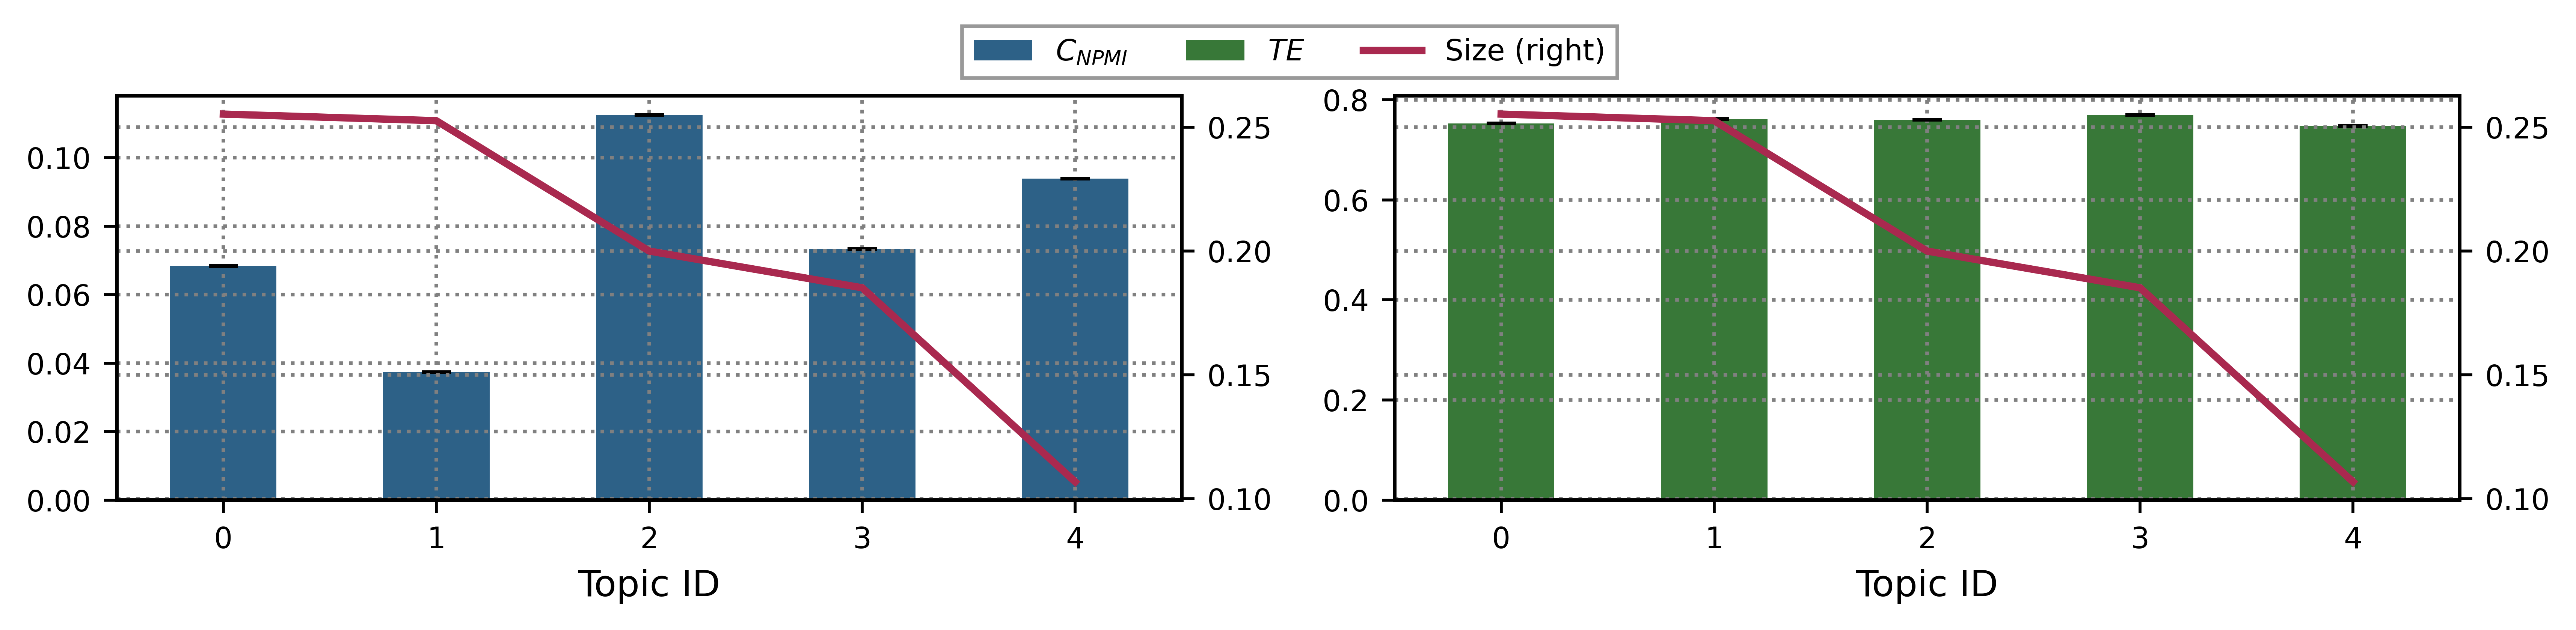

In [308]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (11.5, 2)) #(11.5, 2)
y_repr = ['cohrs_npmi', 'entropies'] #'cohrs_cv',
y_labels = ['$C_{NPMI}$', '$TE$']#'Coherence CV', 
colors = ["#2D6187",  "#387838"] #"#28ABB9",
maxs_mins = [(0.4,1.04),(0.99,1.003)]#(0.98,1.015) 20_cord
#maxs_mins = [(0.1,1.1),(0.9999,1.001)]#(0.98,1.015) neural

labels_all = []
handles_all = []
for yrepr, ylabel, color, max_min, ax in zip(y_repr, y_labels, colors, maxs_mins, axs.flat):
    
    df_root_plot.plot.bar(
        ax=ax,
        y=yrepr + "_mean",
        yerr = yrepr + "_var",
        label=ylabel, use_index=True, stacked=True,
        color = color,
        capsize=4)
    ax2 = df_root_plot.plot(
            ax=ax, 
            y='alphas_mean', kind = 'line', label='Size', color="#A9294F", use_index=True, secondary_y=True)

    ax.grid(True)
    ax.set_xlabel('Topic ID')
    #ax.set_ylabel(ylabel)
    #if yrepr == 'cohrs_npmi':
    #    ax.set_ylim([-0.35, df_root_plot[yrepr + "_mean"].values.max()*max_min[1]])
    #elif yrepr == 'entropies':
    #    ax.set_ylim([0.995, 1.0001])
    #else:
    #    ax.set_ylim([df_root_plot[yrepr + "_mean"].values.min()*max_min[0], df_root_plot[yrepr + "_mean"].values.max()*max_min[1]])
    #ax.set_ylim([df_root_plot[yrepr + "_mean"].values.min()*max_min[0], df_root_plot[yrepr + "_mean"].values.max()*max_min[1]])
    #ax2.set_ylabel('Size')
    ax2.grid(True)
    ax.get_legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    labels_all += labels
    handles_all += handles

handles2, labels2 = ax2.get_legend_handles_labels()

fig.legend(handles_all+handles2, labels_all+labels2, loc='upper center', ncol=4, bbox_to_anchor=(0.513, 1.04),
           frameon=True, shadow=False)

save_fig = folder_save + "/root_model_" + corpus_name + "_" + model_type + ".png"
fig.savefig(save_fig, dpi='figure', bbox_inches='tight')

### Get graphs for HTM-WS submodels

In [309]:
df_ws = df[df.thr==0]
df_ws

,Unnamed: 0,iter,path,cohrs_cv,cohrs_npmi,entropies,td,rbo,alphas,tpc_ids,thr,exp_tpc,tr_tpcs,size
58,0,1,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.707404,0.103295,0.716693,0.906667,0.976231,0.100000,4,0.0,4,10,0.0
63,0,1,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.658049,0.128804,0.726184,0.883333,0.968503,0.125000,0,0.0,0,8,0.0
71,0,1,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.684379,0.103632,0.752239,0.900000,0.968301,0.166666,1,0.0,1,6,0.0
98,0,1,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.709019,0.111829,0.729377,0.841667,0.948186,0.125000,1,0.0,1,8,0.0
108,0,1,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.683768,0.137819,0.740404,0.911111,0.970784,0.166666,0,0.0,0,6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,0,10,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.679453,0.126206,0.725874,0.908333,0.966579,0.125000,0,0.0,0,8,0.0
1514,0,10,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.653887,0.090229,0.752706,0.811111,0.932339,0.166668,1,0.0,1,6,0.0
1516,0,10,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.671013,0.093355,0.713400,0.840000,0.976567,0.100001,4,0.0,4,10,0.0
1540,0,10,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.720238,0.114805,0.731073,0.850000,0.950596,0.125000,1,0.0,1,8,0.0


In [310]:
df_ws = df[df.thr==0]

concat = []
for el in df_ws.tr_tpcs.unique():
    
    df1 = df_ws[df_ws.tr_tpcs==el].groupby('exp_tpc')[['cohrs_cv', 'cohrs_npmi', 'entropies', 'td', 'rbo']].mean()
    df1 = df1.rename(columns={'cohrs_cv': 'cohrs_cv_mean' + "_" + str(el),
                              'cohrs_npmi': 'cohrs_npmi_mean' + "_" + str(el),
                              'entropies': 'entropies_mean' + "_" + str(el),
                              'td': 'td_mean' + "_" + str(el),
                              'rbo': 'rbo_mean' + "_" + str(el),
                             })
    concat.append(df1)

    df2 = df_ws[df_ws.tr_tpcs==el].groupby('exp_tpc')[['cohrs_cv', 'cohrs_npmi', 'entropies', 'td', 'rbo']].var()
    df2 = df2.rename(columns={'cohrs_cv': 'cohrs_cv_var' + "_" + str(el),
                              'cohrs_npmi': 'cohrs_npmi_var' + "_" + str(el),
                              'entropies': 'entropies_var' + "_" + str(el),
                              'td': 'td_var' + "_" + str(el),
                              'rbo': 'rbo_var' + "_" + str(el),
                             })
    concat.append(df2)

df_ws_plot = pd.concat(concat, axis=1, join='inner').reset_index()

df_ws_plot

,exp_tpc,cohrs_cv_mean_10,cohrs_npmi_mean_10,entropies_mean_10,td_mean_10,rbo_mean_10,cohrs_cv_var_10,cohrs_npmi_var_10,entropies_var_10,td_var_10,...,cohrs_cv_mean_6,cohrs_npmi_mean_6,entropies_mean_6,td_mean_6,rbo_mean_6,cohrs_cv_var_6,cohrs_npmi_var_6,entropies_var_6,td_var_6,rbo_var_6
0,0,0.658836,0.124635,0.714248,0.848667,0.951986,0.000119,0.000033,0.000002,0.000465,...,0.674879,0.136644,0.741227,0.907778,0.961622,0.000051,0.000028,6.468602e-07,0.000331,0.000096
1,1,0.730466,0.115473,0.721109,0.810667,0.957564,0.000077,0.000043,0.000002,0.000397,...,0.677174,0.098678,0.750355,0.862222,0.959858,0.000136,0.000046,2.056171e-05,0.001185,0.000182
2,2,0.693759,0.085555,0.715494,0.854000,0.977978,0.000200,0.000082,0.000003,0.000597,...,0.648678,0.070114,0.741759,0.888889,0.962423,0.000791,0.000351,1.536504e-06,0.000686,0.000085
3,3,0.745028,0.132977,0.731942,0.878667,0.979142,0.000270,0.000081,0.000004,0.000136,...,0.711050,0.119070,0.755706,0.933333,0.984958,0.000291,0.000125,1.787376e-06,0.000466,0.000044
4,4,0.692611,0.098749,0.715773,0.854000,0.969682,0.000336,0.000014,0.000002,0.000627,...,0.700376,0.115678,0.739652,0.930000,0.981447,0.000147,0.000097,1.306164e-06,0.000139,0.000014


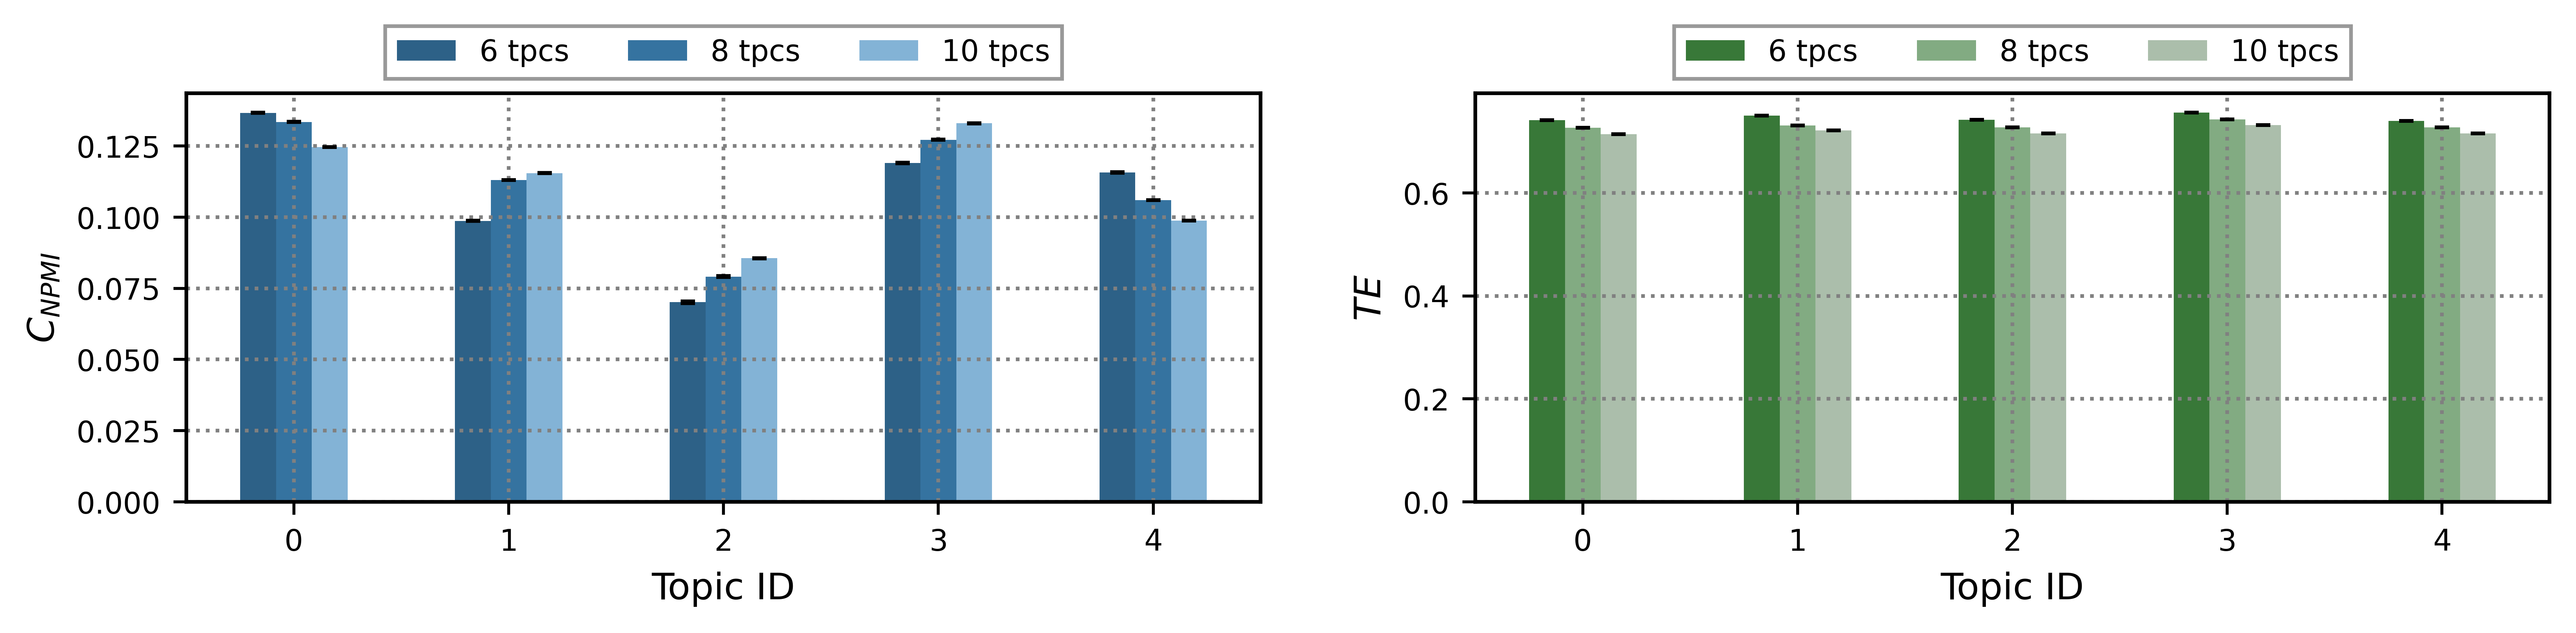

In [311]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (11.5, 2))
y_repr = ['cohrs_npmi', 'entropies'] #'cohrs_cv', 
y_labels = ['$C_{NPMI}$', '$TE$'] #'Coherence CV', 
labels_save = ['Coherence NPMI', 'Entropy']
colors = [['#2D6187','#3573A0','#83B3D6'],
          ['#387838', '#82AB82','#ABBEAB']] #['#28ABB9','#2dc1d0','#8adde6']
maxs_mins = [(0.95,1.02),(0.99,1.003)] #(0.99,1.02),

for yrepr, ylabel, label_save, color, max_min, ax in zip(y_repr, y_labels, labels_save, colors, maxs_mins, axs.flat):
    aux = [df_ws_plot[yrepr + "_var_6"].values,
           df_ws_plot[yrepr + "_var_8"].values, 
           df_ws_plot[yrepr + "_var_10"].values]
    y_aux = [yrepr + "_mean_6", yrepr + "_mean_8", yrepr + "_mean_10"]
    df_ws_plot.plot.bar(
        x='exp_tpc',
        ax=ax,
        y= y_aux,
        yerr = aux,
        label=['6 tpcs', '8 tpcs', '10 tpcs'],
        color=color,
        #ecolor='gray',
        capsize=2)
    
    ax.grid(True)
    ax.set_xlabel('Topic ID')
    ax.set_ylabel(ylabel)
    #ax.set_ylim([df_ws_plot[y_aux].values.min()*max_min[0], df_ws_plot[y_aux].values.max()*max_min[1]]) # decomment for mallet models
    #if yrepr == 'cohrs_npmi':
    #    ax.set_ylim([-0.2, 0])
    #elif yrepr == 'entropies':
    #    ax.set_ylim([0.998, 1.000])
    #else:
    #ax.set_ylim([df_root_plot[yrepr + "_mean"].values.min()*max_min[0], df_root_plot[yrepr + "_mean"].values.max()*max_min[1]])
    ax.set_xticklabels(ax.get_xticks(), rotation = 0)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          frameon=True, shadow=False, ncol=3)
    
plt.show()

save_fig = folder_save + "/htm_ws_" + corpus_name + "_" + model_type + ".png"
fig.savefig(save_fig, dpi='figure', bbox_inches='tight')

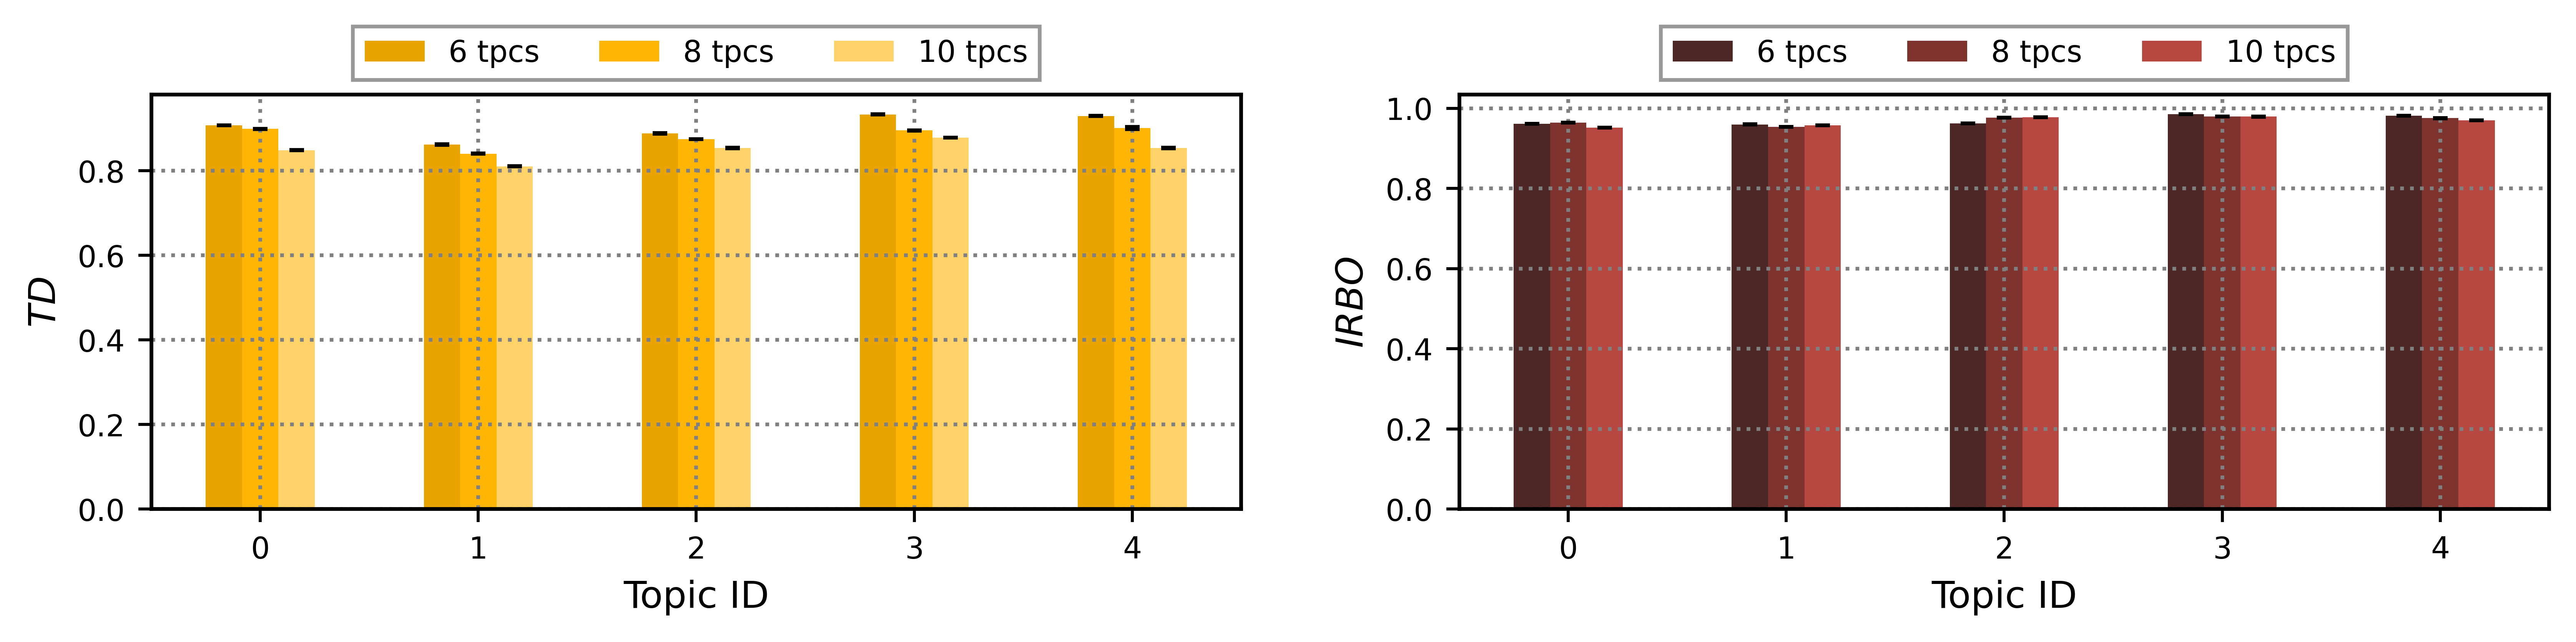

In [312]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (11.5, 2))
y_repr = ['td', 'rbo'] 
y_labels = ['$TD$', '$IRBO$']
labels_save = ['TD', 'IRBO']
colors = [['#e9a400','#ffb503','#ffd369'],
          ['#4c2726', '#7e332e','#b74841']]
maxs_mins = [(0.985,1.01),(0.99,1.01)] 

for yrepr, ylabel, label_save, color, max_min, ax in zip(y_repr, y_labels, labels_save, colors, maxs_mins, axs.flat):
    aux = [df_ws_plot[yrepr + "_var_6"].values,
           df_ws_plot[yrepr + "_var_8"].values, 
           df_ws_plot[yrepr + "_var_10"].values]
    y_aux = [yrepr + "_mean_6", yrepr + "_mean_8", yrepr + "_mean_10"]
    df_ws_plot.plot.bar(
        x='exp_tpc',
        ax=ax,
        y= y_aux,
        yerr = aux,
        label=['6 tpcs', '8 tpcs', '10 tpcs'],
        color=color,
        #ecolor='gray',
        capsize=2)
    
    ax.grid(True)
    ax.set_xlabel('Topic ID')
    ax.set_ylabel(ylabel)
    #ax.set_ylim([df_ws_plot[y_aux].values.min()*max_min[0], df_ws_plot[y_aux].values.max()*max_min[1]])
    ax.set_xticklabels(ax.get_xticks(), rotation = 0)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          frameon=True, shadow=False, ncol=3)
    
plt.show()

save_fig = folder_save + "/htm_ws_diversity_" + corpus_name + "_" + model_type + ".png"
fig.savefig(save_fig, dpi='figure', bbox_inches='tight')

In [282]:
prop_min = (600*100)/root_size
prop_max = 30

### Get graphs for HTM-DS submodels

In [314]:
df_ds = df[df.thr>0]
df_ds

,Unnamed: 0,iter,path,cohrs_cv,cohrs_npmi,entropies,td,rbo,alphas,tpc_ids,thr,exp_tpc,tr_tpcs,size
55,0,1,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.598207,0.100538,0.720373,0.841667,0.951237,0.125000,1,0.7,1,8,17.681588
56,0,1,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.625349,0.096787,0.725368,0.866667,0.970944,0.125000,0,0.3,0,8,32.973890
57,0,1,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.496553,0.107207,0.736393,0.888889,0.964630,0.166667,2,0.8,2,6,11.857295
59,0,1,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.608510,0.090153,0.738586,0.955556,0.978316,0.166667,1,0.4,1,6,26.971324
60,0,1,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.664192,0.119988,0.718276,0.853333,0.973526,0.100000,3,0.8,3,10,10.596343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,0,10,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.596683,0.092634,0.706937,0.826667,0.963377,0.100000,0,0.6,0,10,20.227406
1550,0,10,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.649928,0.126307,0.745514,0.955556,0.981473,0.166667,3,0.7,3,6,12.572559
1552,0,10,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.624703,0.100315,0.729625,0.866667,0.970199,0.125000,3,0.4,3,8,19.092550
1553,0,10,/export/usuarios_ml4ds/lbartolome/Datasets/COR...,0.632101,0.099342,0.712883,0.840000,0.973527,0.100000,0,0.2,0,10,38.132922


In [329]:
x_ticks = list(set(df_ds.thr.tolist()))
x_ticks.sort()
x_ticks

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

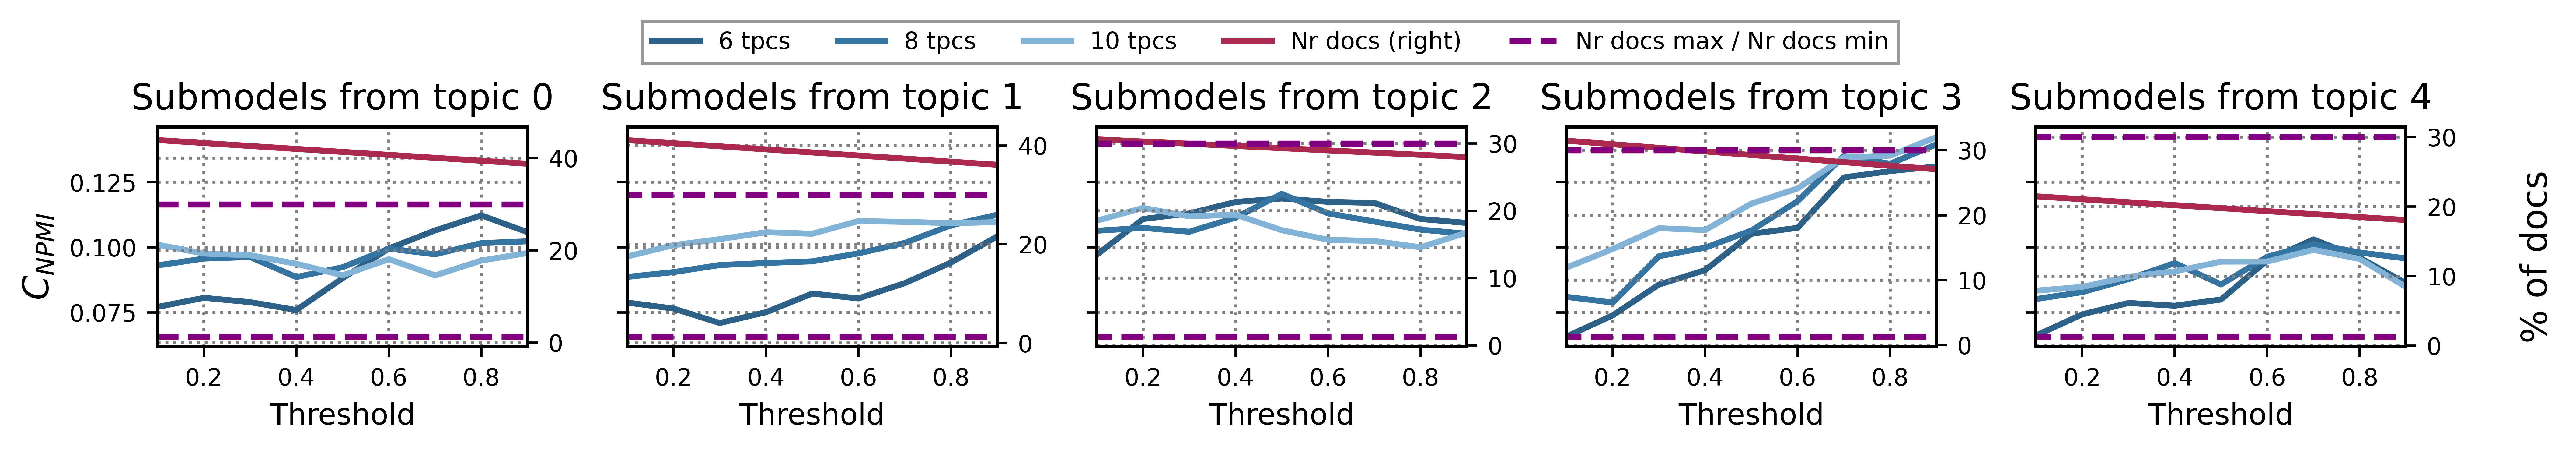

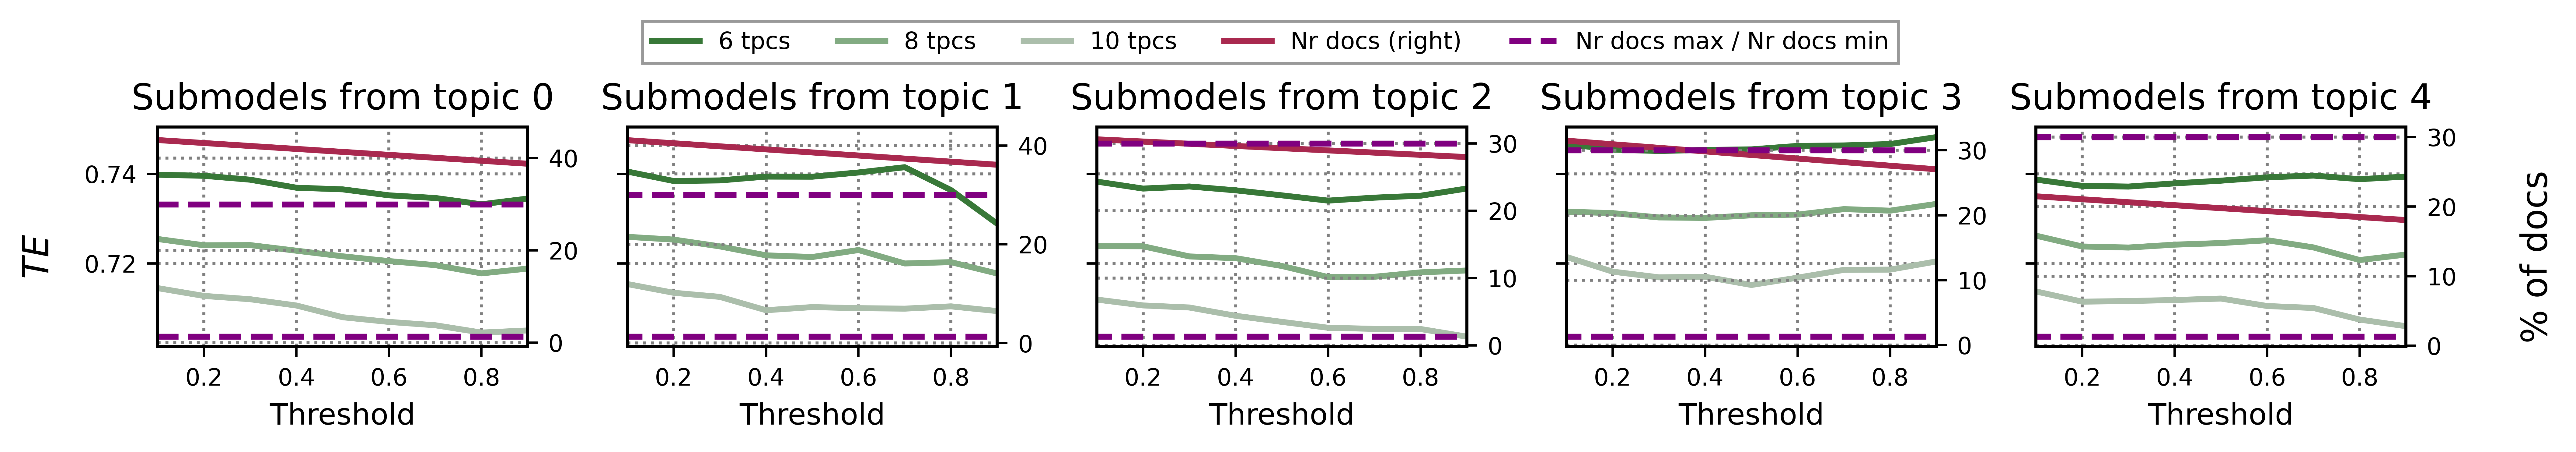

In [338]:
metrics_display = ['cohrs_npmi', 'entropies']#'cohrs_cv',
y_labels = ['$C_{NPMI}$', '$TE$'] #'Coherence CV', 
labels_save = ['Coherence NPMI', 'Entropy']
colors = [['#2D6187','#3573A0','#83B3D6'],
          ['#387838', '#82AB82','#ABBEAB']] #['#28ABB9','#2dc1d0','#8adde6'],
maxs_mins = [(1,1.45),(0.98,1.05)] #(0.9,1.12),
#maxs_mins = [(0.1,1.5),(1.02,1.015)]#(0.75,1.02),

for metric,label,label_save,color,max_min in zip(metrics_display,y_labels,labels_save,colors,maxs_mins):
    
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize = (11.5, 2), sharex=True, sharey=True) # for 5 topics: (25.5, 4.8)

    for tpc, ax in zip(sorted(df_ds.exp_tpc.unique()), axs.flat):
        aux_df_ds = df_ds[df_ds.exp_tpc==tpc]
        concat = []
        for el in aux_df_ds.tr_tpcs.unique():

            df1 = aux_df_ds[aux_df_ds.tr_tpcs==el].groupby('thr')[[metric,'size']].mean()
            df1 = df1.rename(columns={metric: metric + '_mean_' + str(el),
                                      'size':  'size_mean' + "_" + str(el)})
            concat.append(df1)

            df2 = aux_df_ds[aux_df_ds.tr_tpcs==el].groupby('thr')[[metric,'size']].var()
            df2 = df2.rename(columns={metric: metric + '_var_' + str(el),
                                      'size':  'size_var' + "_" + str(el)})
            concat.append(df2)

        aux_df_ds_plot = pd.concat(concat, axis=1, join='inner').reset_index()
                
        aux = [aux_df_ds_plot[metric + "_var_6"].values,
               aux_df_ds_plot[metric + "_var_8"].values, 
               aux_df_ds_plot[metric + "_var_10"].values]
            
        y_aux = [metric + "_mean_6", metric + "_mean_8", metric + "_mean_10"]

        aux_df_ds_plot.plot(
            ax=ax,
            x='thr',
            y=y_aux,
            label=['6 tpcs', '8 tpcs', '10 tpcs'],
            color=color,
            linewidth=2,  # Adjust the line width as needed
            rot=0,
            kind='line'  # Specify 'line' to create a line graph
        )

        ax2 = aux_df_ds_plot.plot(
                ax=ax, 
                y='size_mean_6', 
                kind = 'line',
                color='#A9294F',
                label='Nr docs', 
                secondary_y=True)

        ax2.hlines(y=[prop_max,prop_min], xmin=-1, xmax=len(aux_df_ds_plot.thr.unique()),
                   colors='purple', linestyles='--',
                   label='Nr docs max / Nr docs min')
        #ax2.set_ylim([0, 32])
        ax.set_xlim(min(x_ticks), max(x_ticks))
        ax.set_xlabel('Threshold')
        ax.set_title(f'Submodels from topic {tpc}')
        ax.get_legend().remove()
        ax.grid(True)
        ax2.grid(True)

    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    fig.legend(handles+handles2, labels+labels2, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.08),
              frameon=True, shadow=False)
    
    
    fig.text(-0.01, 0.5, label, va='center', rotation='vertical')
    fig.text(1.01, 0.5,'% of docs', va='center', rotation='vertical')
    fig.tight_layout()
    
    save_fig = folder_save + "/htm_ds_" + corpus_name + "_" + model_type + "_" + label_save + ".png"
    fig.savefig(save_fig, dpi='figure', bbox_inches='tight')

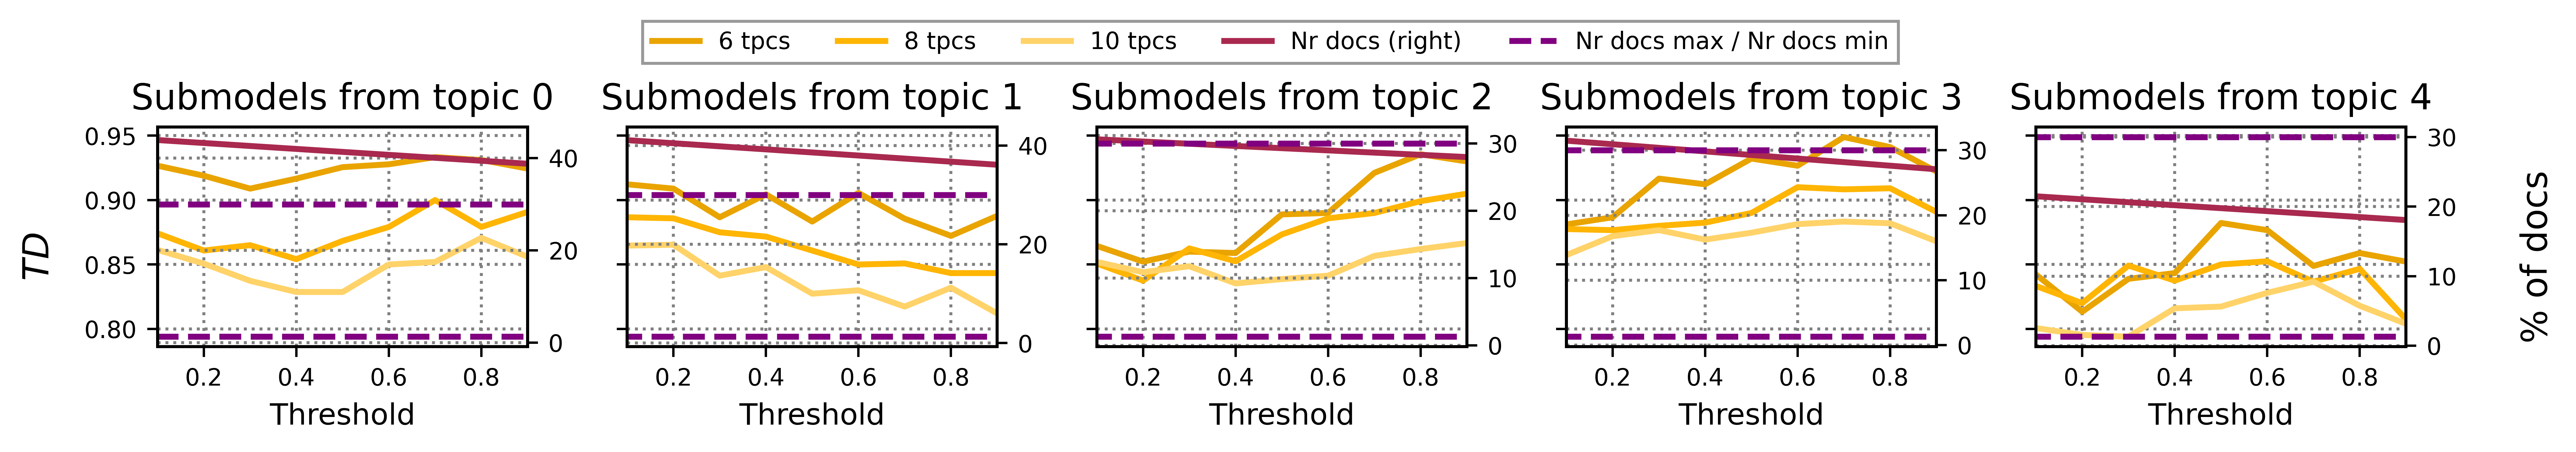

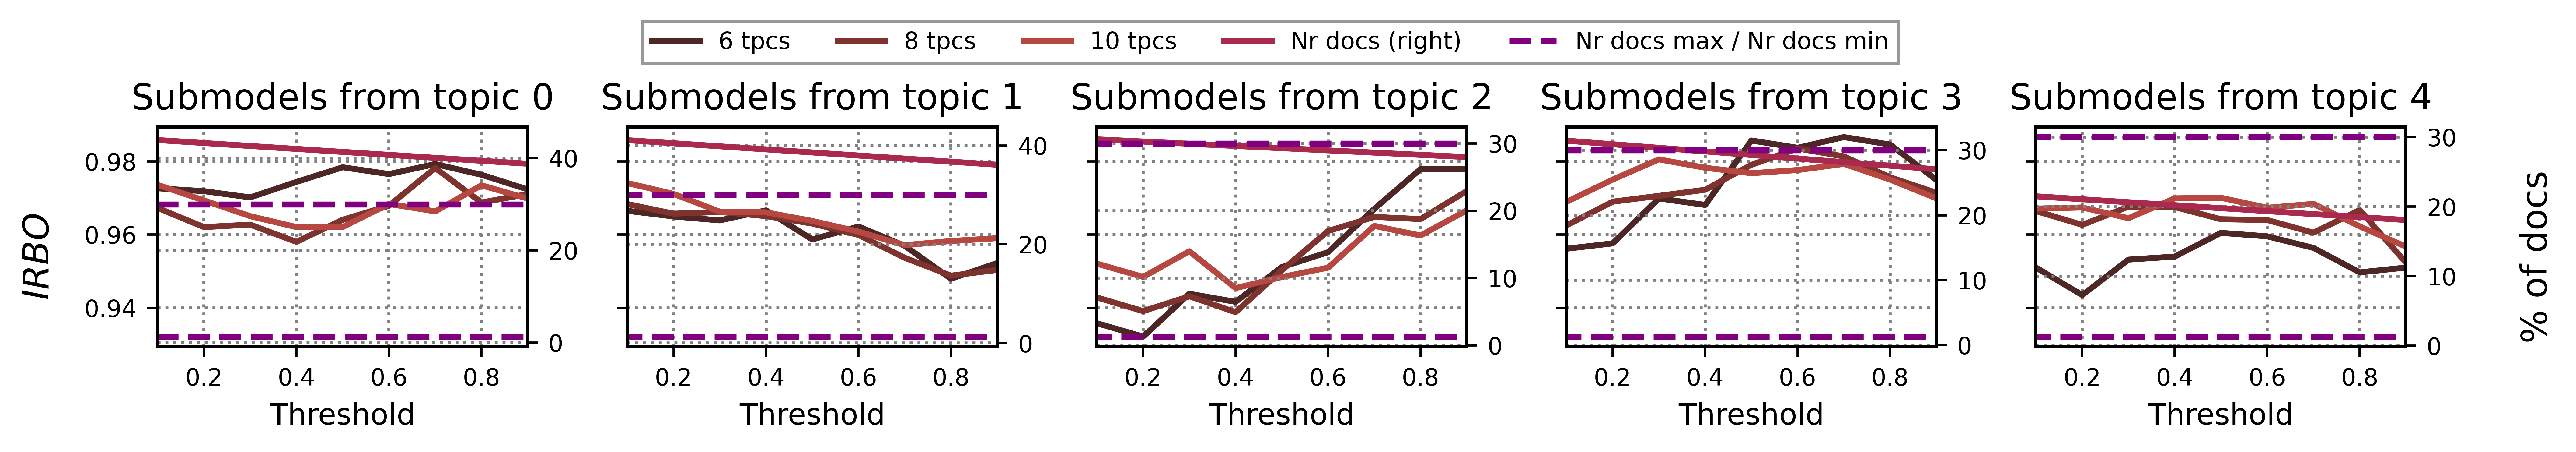

In [339]:
metrics_display = ['td', 'rbo']
y_labels = ['$TD$', '$IRBO$']
labels_save = ['TD', 'IRBO']
colors = [['#e9a400','#ffb503','#ffd369'],
          ['#4c2726', '#7e332e','#b74841']]
maxs_mins = [(0.95,1.2),(0.95,1.08)] 

for metric,label,label_save,color,max_min in zip(metrics_display,y_labels,labels_save,colors,maxs_mins):
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize = (11.5, 2), sharex=True, sharey=True) # for 5 topics: (25.5, 4.8)

    for tpc, ax in zip(sorted(df_ds.exp_tpc.unique()), axs.flat):
        aux_df_ds = df_ds[df_ds.exp_tpc==tpc]
        concat = []
        for el in aux_df_ds.tr_tpcs.unique():

            df1 = aux_df_ds[aux_df_ds.tr_tpcs==el].groupby('thr')[[metric,'size']].mean()
            df1 = df1.rename(columns={metric: metric + '_mean_' + str(el),
                                      'size':  'size_mean' + "_" + str(el)})
            concat.append(df1)

            df2 = aux_df_ds[aux_df_ds.tr_tpcs==el].groupby('thr')[[metric,'size']].var()
            df2 = df2.rename(columns={metric: metric + '_var_' + str(el),
                                      'size':  'size_var' + "_" + str(el)})
            concat.append(df2)

        aux_df_ds_plot = pd.concat(concat, axis=1, join='inner').reset_index()
                
        aux = [aux_df_ds_plot[metric + "_var_6"].values,
               aux_df_ds_plot[metric + "_var_8"].values, 
               aux_df_ds_plot[metric + "_var_10"].values]
            
        y_aux = [metric + "_mean_6", metric + "_mean_8", metric + "_mean_10"]

        aux_df_ds_plot.plot(
            ax=ax,
            x='thr',
            y=y_aux,
            label=['6 tpcs', '8 tpcs', '10 tpcs'],
            color=color,
            linewidth=2,  # Adjust the line width as needed
            rot=0,
            kind='line'  # Specify 'line' to create a line graph
        )

        ax2 = aux_df_ds_plot.plot(
                ax=ax, 
                y='size_mean_6', 
                kind = 'line',
                color='#A9294F',
                label='Nr docs', 
                secondary_y=True)

        ax2.hlines(y=[prop_max,prop_min], xmin=-1, xmax=len(aux_df_ds_plot.thr.unique()),
                   colors='purple', linestyles='--',
                   label='Nr docs max / Nr docs min')
        
        ax.set_xlim(min(x_ticks), max(x_ticks))
        ax.set_xlabel('Threshold')
        ax.set_title(f'Submodels from topic {tpc}')
        ax.get_legend().remove()
        ax.grid(True)
        ax2.grid(True)

    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    fig.legend(handles+handles2, labels+labels2, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.08),
              frameon=True, shadow=False)
    
    
    fig.text(-0.01, 0.5, label, va='center', rotation='vertical')
    fig.text(1.01, 0.5,'% of docs', va='center', rotation='vertical')
    fig.tight_layout()
    
    save_fig = folder_save + "/htm_ds_diversity_" + corpus_name + "_" + model_type + "_" + label_save + ".png"
    fig.savefig(save_fig, dpi='figure', bbox_inches='tight')